# **Imports and Setup**
First, we'll import the necessary libraries and set up the environment.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import time
import os
from PIL import Image
import pyarrow.parquet as pq
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Set GPU configuration if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("Using CPU")

TensorFlow version: 2.18.0
Using CPU


# **Data Loading and Preprocessing**
We'll load the data from the parquet files, decode the images, and prepare them for TensorFlow. The key here is to ensure that all images are stacked into a single NumPy array with a consistent shape.
* Load and Convert Images

In [2]:
import os
import cv2
import numpy as np
import pandas as pd

# Base dataset directory
BASE_DIR = r"C:\Users\jeeri\OneDrive\Documents\01testproject\Alzheimer_s Dataset"

# Disease labels mapping
disease_label_from_category = {
    "MildDemented": 0,
    "ModerateDemented": 1,
    "NonDemented": 2,
    "VeryMildDemented": 3,
}

# Function to load images from folders
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            if img is not None:
                images.append(img)
                labels.append(label)
    
    return images, labels

# Function to load dataset
def load_dataset(data_dir):
    all_images = []
    all_labels = []
    
    for category in disease_label_from_category.keys():  # Loop through disease categories
        folder_path = os.path.join(data_dir, category)
        if os.path.exists(folder_path):  # Ensure folder exists
            images, labels = load_images_from_folder(folder_path, disease_label_from_category[category])
            all_images.extend(images)
            all_labels.extend(labels)
    
    return np.array(all_images), np.array(all_labels)

# Load training data
train_images, train_labels = load_dataset(os.path.join(BASE_DIR, "train"))

# Load test data
test_images, test_labels = load_dataset(os.path.join(BASE_DIR, "test"))

print("Training and test data loaded successfully.")
print(f"Train Data: {len(train_images)} images, Test Data: {len(test_images)} images")


Training and test data loaded successfully.
Train Data: 5121 images, Test Data: 1279 images


* Verify Image Shapes
> Before stacking the images, it's crucial to ensure that all images have the same dimensions. If not, we'll need to resize them.

In [3]:
# Base dataset directory
BASE_DIR = r"C:\Users\jeeri\OneDrive\Documents\01testproject\Alzheimer_s Dataset"

# Image size for resizing
IMG_SIZE = (128, 128)  # Change to desired dimensions

# Disease labels mapping
disease_label_from_category = {
    "MildDemented": 0,
    "ModerateDemented": 1,
    "NonDemented": 2,
    "VeryMildDemented": 3,
}

# Function to load and preprocess images
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)  # Resize to (128x128)
                images.append(img)
                labels.append(label)
    
    return images, labels

# Function to load dataset
def load_dataset(data_dir):
    all_images = []
    all_labels = []
    
    for category in disease_label_from_category.keys():
        folder_path = os.path.join(data_dir, category)
        if os.path.exists(folder_path):
            images, labels = load_images_from_folder(folder_path, disease_label_from_category[category])
            all_images.extend(images)
            all_labels.extend(labels)
    
    return np.array(all_images), np.array(all_labels)

# Load training data
train_images, train_labels = load_dataset(os.path.join(BASE_DIR, "train"))

# Load test data
test_images, test_labels = load_dataset(os.path.join(BASE_DIR, "test"))

print("Training and test data loaded successfully.")
print(f"Train Data: {len(train_images)} images, Test Data: {len(test_images)} images")




Training and test data loaded successfully.
Train Data: 5121 images, Test Data: 1279 images


In [4]:
# Verify the shape of images
print("Image Shape:", train_images.shape)  # Expected: (num_samples, 128, 128)


Image Shape: (5121, 128, 128)


* Stack Images into NumPy Arrays
> Convert the list of image arrays into a single NumPy array. This ensures that TensorFlow can handle the data efficiently.

In [5]:
# Convert lists of image arrays to NumPy arrays
X_train = np.stack(train_images)  # Shape: (num_samples, 128, 128)
X_test = np.stack(test_images)    # Shape: (num_samples, 128, 128)

# Expand dimensions to add the channel dimension (for grayscale)
X_train = X_train[..., np.newaxis]  # Shape: (num_samples, 128, 128, 1)
X_test = X_test[..., np.newaxis]    # Shape: (num_samples, 128, 128, 1)

# Convert labels to NumPy arrays
Y_train = np.array(train_labels)
Y_test = np.array(test_labels)

print(f"X_train shape: {X_train.shape}")  # Expected: (num_samples, 128, 128, 1)
print(f"Y_train shape: {Y_train.shape}")  # Expected: (num_samples,)
print(f"X_test shape: {X_test.shape}")    # Expected: (num_samples, 128, 128, 1)
print(f"Y_test shape: {Y_test.shape}")    # Expected: (num_samples,)


X_train shape: (5121, 128, 128, 1)
Y_train shape: (5121,)
X_test shape: (1279, 128, 128, 1)
Y_test shape: (1279,)


* Split Training Data into Training and Validation Sets

In [6]:
# Split training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 4096
Validation set size: 1025


* Normalize Images
> Normalize the pixel values to the [0,1] range.

In [7]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

* Create TensorFlow Datasets
> Now that the data is properly formatted, create TensorFlow datasets.

In [8]:
# Parameters
N_CLASSES = len(np.unique(Y_train))
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# **Exploratory Data Analysis**
Visualize some samples and check the distribution of classes to understand your dataset better.

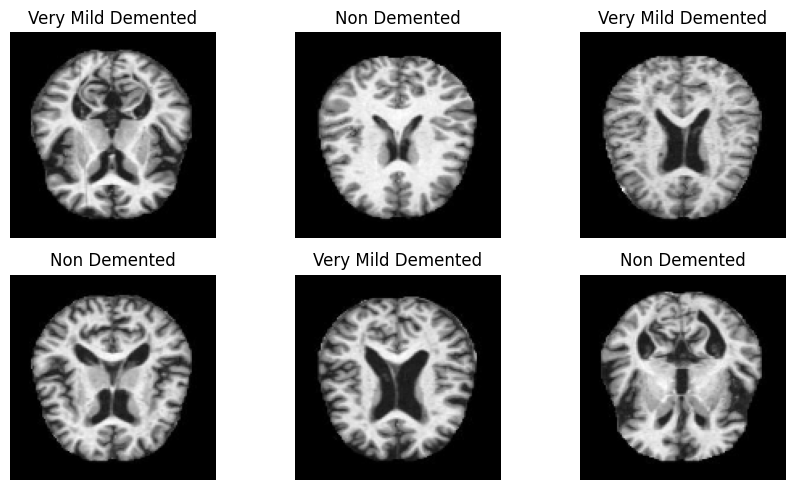

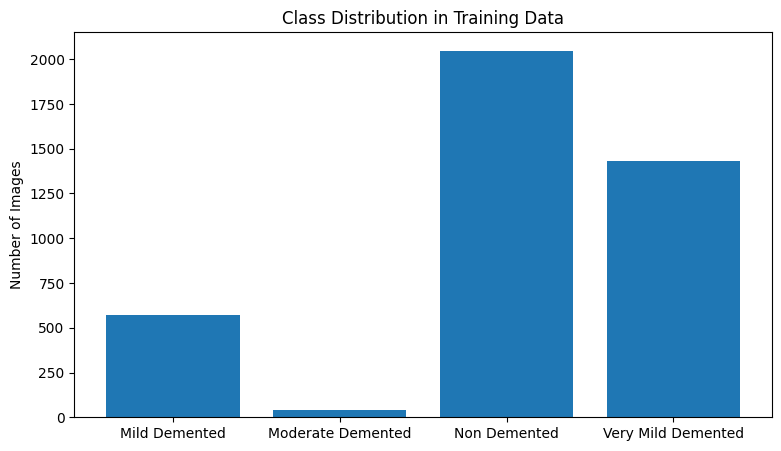

Total samples in training data = 4096


In [9]:
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

# Visualize sample images
fig, ax = plt.subplots(2, 3, figsize=(9, 5))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(X_train))
    axes.imshow(X_train[rand].squeeze(), cmap="gray")
    axes.set_title(disease_label_from_category[int(Y_train[rand])])  # Fix here
    axes.axis('off')

plt.tight_layout()
plt.show()

# Class distribution
plt.figure(figsize=(9, 5))
plt.bar(np.arange(0, 4, 1), pd.Series(Y_train).value_counts().sort_index())
plt.ylabel("Number of Images")
plt.xticks(np.arange(0, 4, 1), labels=[disease_label_from_category[i] for i in range(4)])
plt.title("Class Distribution in Training Data")
plt.show()

print(f"Total samples in training data = {X_train.shape[0]}")

* Analyze Class Distribution

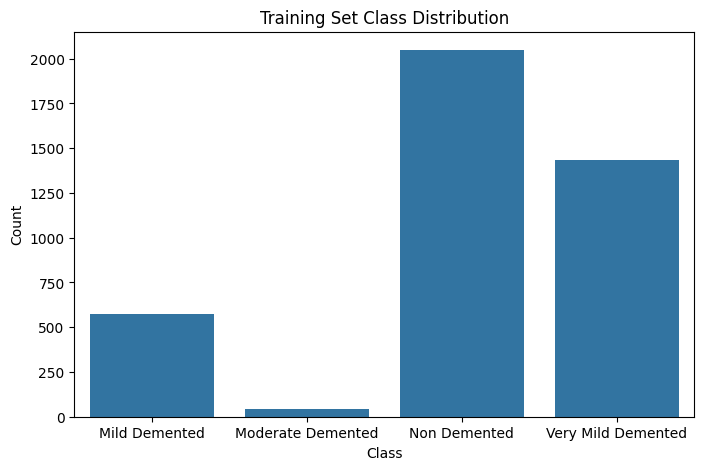

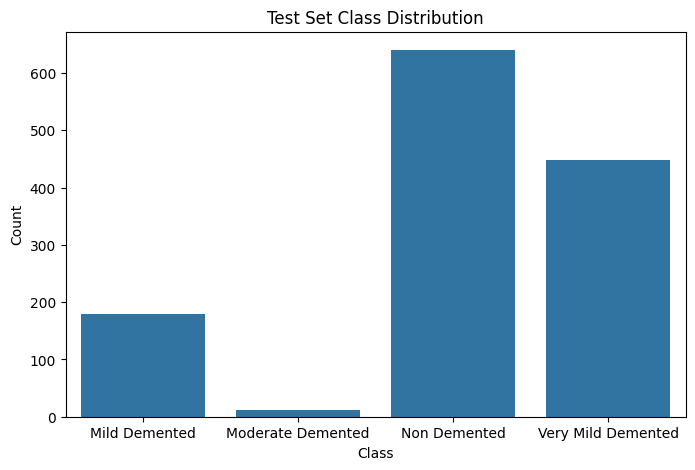

In [10]:
import seaborn as sns

# Function to plot class distribution
def plot_class_distribution(labels, title):
    plt.figure(figsize=(8,5))
    sns.countplot(x=labels)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(ticks=range(len(disease_label_from_category)), 
               labels=[disease_label_from_category[i] for i in range(4)])
    plt.show()

# Plot distributions
plot_class_distribution(Y_train, "Training Set Class Distribution")
plot_class_distribution(Y_test, "Test Set Class Distribution")

* Handle Class Imbalance

# **Method 1: Baseline CNN**
We'll start with a simple Convolutional Neural Network (CNN) without any data augmentation.
* Model Definition

In [11]:
# Define the Baseline CNN model
def create_baseline_cnn(input_shape=(128, 128, 1), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

baseline_cnn = create_baseline_cnn()
baseline_cnn.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

baseline_cnn.summary()

# Plot the model architecture
plot_model(baseline_cnn, show_shapes=True, show_layer_names=True)

c:\Program Files\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,408,452 (32.08 MB)

 Trainable params: 8,408,260 (32.07 MB)

 Non-trainable params: 192 (768.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


* Training the Baseline Model

In [12]:
# Define callbacks
# Save the best model based on validation accuracy
checkpoint_cb = ModelCheckpoint(
    filepath="baseline_cnn.keras",  # File path to save the model
    save_best_only=True,            # Only save when the model is better
    monitor='val_accuracy',         # Metric to monitor
    mode='max',                     # Mode: 'max' for accuracy
    verbose=0                       # Verbosity mode
)
# Stop training when validation accuracy doesn't improve for 5 epochs
earlystop_cb = EarlyStopping(
    monitor='val_accuracy',         # Metric to monitor
    patience=5,                     # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,      # Restore model weights from the epoch with the best value of the monitored metric
    mode='max',                     # Mode: 'max' for accuracy
    verbose=1                       # Verbosity mode
)

# Train the model
history_baseline = baseline_cnn.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - accuracy: 0.5332 - loss: 8.6707 - val_accuracy: 0.5015 - val_loss: 1.0253
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 252ms/step - accuracy: 0.8877 - loss: 0.2912 - val_accuracy: 0.5668 - val_loss: 1.4838
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 255ms/step - accuracy: 0.9566 - loss: 0.1226 - val_accuracy: 0.5688 - val_loss: 1.4024
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.9964 - loss: 0.0330 - val_accuracy: 0.8078 - val_loss: 0.8811
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.9083 - val_loss: 0.2216
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9834 - val_loss: 0.0609
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9844 - val_loss: 0.0488
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 1.0000 -

* Evaluation

In [13]:
# Load the best model
baseline_cnn.load_weights("baseline_cnn.keras")

# Evaluate on training data (not recommended for final evaluation)
train_predictions = baseline_cnn.predict(train_ds)
train_pred_labels = np.argmax(train_predictions, axis=1)
train_true_labels = Y_train

print("Training Accuracy:", accuracy_score(train_true_labels, train_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(train_true_labels, train_pred_labels))
print("\nClassification Report:")
print(classification_report(train_true_labels, train_pred_labels, target_names=[disease_label_from_category[i] for i in range(4)]))

# Evaluate on test data
test_predictions = baseline_cnn.predict(test_ds)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = Y_test

print("Test Accuracy:", accuracy_score(test_true_labels, test_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(test_true_labels, test_pred_labels))
print("\nClassification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=[disease_label_from_category[i] for i in range(4)]))

128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step
Training Accuracy: 0.388916015625
Confusion Matrix:
[[  81    7  290  195]
 [   6    0   20   16]
 [ 290   22 1013  723]
 [ 196   13  725  499]]

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.14      0.14      0.14       573
 Moderate Demented       0.00      0.00      0.00        42
      Non Demented       0.49      0.49      0.49      2048
Very Mild Demented       0.35      0.35      0.35      1433

          accuracy                           0.39      4096
         macro avg       0.25      0.25      0.25      4096
      weighted avg       0.39      0.39      0.39      4096

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step
Test Accuracy: 0.6841282251759186
Confusion Matrix:
[[ 45   0  75  59]
 [  2   1   0   9]
 [  7   0 536  97]
 [ 11   0 144 293]]

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.69      0.25      0.37  

# **Method 2: CNN with Data Augmentation**
To enhance the model's generalization, we'll introduce data augmentation techniques during training.
* Data Augmentation Setup

In [14]:
# Define data augmentation layers
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.2),
    layers.GaussianNoise(0.1)
])

# Define a new model that includes data augmentation
def create_augmented_cnn(input_shape=(128, 128, 1), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=x)
    return model

augmented_cnn = create_augmented_cnn()
augmented_cnn.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

augmented_cnn.summary()

# Plot the model architecture
plot_model(augmented_cnn, show_shapes=True, show_layer_names=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,408,452 (32.08 MB)

 Trainable params: 8,408,260 (32.07 MB)

 Non-trainable params: 192 (768.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


* Training the Augmented Model

In [15]:
# Define callbacks
checkpoint_cb_aug = ModelCheckpoint(
    filepath="augmented_cnn.keras",  # File path to save the model
    save_best_only=True,            # Only save when the model is better
    monitor='val_accuracy',         # Metric to monitor
    mode='max',                     # Mode: 'max' for accuracy
    verbose=0                       # Verbosity mode
)
# Stop training when validation accuracy doesn't improve for 5 epochs
earlystop_cb_aug = EarlyStopping(
    monitor='val_accuracy',         # Metric to monitor
    patience=10,                     # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,      # Restore model weights from the epoch with the best value of the monitored metric
    mode='max',                     # Mode: 'max' for accuracy
    verbose=1                       # Verbosity mode
)

# Train the augmented model
history_augmented = augmented_cnn.fit(
    train_ds,
    epochs=100, 
    validation_data=val_ds,
    callbacks=[checkpoint_cb_aug, earlystop_cb_aug]
)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 64s 407ms/step - accuracy: 0.4460 - loss: 10.5265 - val_accuracy: 0.4995 - val_loss: 1.3937
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.5073 - loss: 1.2255 - val_accuracy: 0.4995 - val_loss: 1.8431
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 317ms/step - accuracy: 0.5169 - loss: 1.1790 - val_accuracy: 0.4995 - val_loss: 1.9158
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 325ms/step - accuracy: 0.5147 - loss: 1.2027 - val_accuracy: 0.4995 - val_loss: 2.1274
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - accuracy: 0.5560 - loss: 1.0442 - val_accuracy: 0.4995 - val_loss: 1.2762
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 76s 276ms/step - accuracy: 0.5381 - loss: 0.9939 - val_accuracy: 0.4995 - val_loss: 1.2513
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 25s 193ms/step - accuracy: 0.5514 - loss: 0.9569 - val_accuracy: 0.4995 - val_loss: 1.1583
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5466 

*Note: Since data augmentation can introduce more variability, training for a few more epochs might help the model converge better.*
* Evaluation

In [16]:
# Load the best augmented model
augmented_cnn.load_weights("augmented_cnn.keras")

# Evaluate on training data
train_predictions_aug = augmented_cnn.predict(train_ds)
train_pred_labels_aug = np.argmax(train_predictions_aug, axis=1)
train_true_labels_aug = Y_train

print("Augmented Training Accuracy:", accuracy_score(train_true_labels_aug, train_pred_labels_aug))
print("Confusion Matrix:")
print(confusion_matrix(train_true_labels_aug, train_pred_labels_aug))
print("\nClassification Report:")
print(classification_report(train_true_labels_aug, train_pred_labels_aug, target_names=[disease_label_from_category[i] for i in range(4)]))

# Evaluate on test data
test_predictions_aug = augmented_cnn.predict(test_ds)
test_pred_labels_aug = np.argmax(test_predictions_aug, axis=1)
test_true_labels_aug = Y_test

print("Augmented Test Accuracy:", accuracy_score(test_true_labels_aug, test_pred_labels_aug))
print("Confusion Matrix:")
print(confusion_matrix(test_true_labels_aug, test_pred_labels_aug))
print("\nClassification Report:")
print(classification_report(test_true_labels_aug, test_pred_labels_aug, target_names=[disease_label_from_category[i] for i in range(4)]))

128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step
Augmented Training Accuracy: 0.501708984375
Confusion Matrix:
[[   0    0  566    7]
 [   0    0   42    0]
 [   0    0 2044    4]
 [   0    0 1422   11]]

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.00      0.00      0.00       573
 Moderate Demented       0.00      0.00      0.00        42
      Non Demented       0.50      1.00      0.67      2048
Very Mild Demented       0.50      0.01      0.02      1433

          accuracy                           0.50      4096
         macro avg       0.25      0.25      0.17      4096
      weighted avg       0.43      0.50      0.34      4096

 3/40 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Augmented Test Accuracy: 0.5003909304143862
Confusion Matrix:
[[  0   0 179   0]
 [  0   0  12   0]
 [  0   0 640   0]
 [  0   0 448   0]]

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.00      0.00      0.00       179
 Moderate Demented       0.00      0.00      0.00        12
      Non Demented       0.50      1.00      0.67       640
Very Mild Demented       0.00      0.00      0.00       448

          accuracy                           0.50      1279
         macro avg       0.13      0.25      0.17      1279
      weighted avg       0.25      0.50      0.33      1279



C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

# Method 3: Transfer Learning with Pre-trained Models
We'll leverage transfer learning using a pre-trained model like ResNet50. Since ResNet50 expects 3-channel images, we'll replicate the grayscale channel.
* Data Preparation for Transfer Learning

In [17]:
import tensorflow as tf

# Function to convert grayscale to RGB using TensorFlow's built-in function
def grayscale_to_rgb_tf(img):
    return tf.image.grayscale_to_rgb(img)

# Function to preprocess images for transfer learning
def preprocess_image_rgb_tf(img, label):
    img = grayscale_to_rgb_tf(img)
    img = tf.image.resize(img, [224, 224])  # Resize to match ResNet50 input
    return img, label

# Function to apply normalization
def preprocess_transfer_tf(img, lbl):
    img, lbl = preprocess_image_rgb_tf(img, lbl)
    img = img / 255.0  # Normalize to [0,1]
    return img, lbl

# Create TensorFlow datasets for transfer learning
train_ds_tf = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds_tf = train_ds_tf.map(preprocess_transfer_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_tf = train_ds_tf.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds_tf = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_ds_tf = val_ds_tf.map(preprocess_transfer_tf, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_tf = val_ds_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds_tf = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds_tf = test_ds_tf.map(preprocess_transfer_tf, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_tf = test_ds_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

* Model Definition
> We'll use ResNet50 with frozen base layers and a custom top.

In [18]:
# Load the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Define the transfer learning model
def create_transfer_learning_model(base_model, num_classes=4):
    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

transfer_model = create_transfer_learning_model(base_model)
transfer_model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

transfer_model.summary()

# Plot the model architecture
plot_model(transfer_model, show_shapes=True, show_layer_names=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


* Training the Transfer Learning Model

In [19]:
# Define callbacks
checkpoint_cb_tf = ModelCheckpoint(
    filepath="transfer_learning_resnet50.keras",  # File path to save the model
    save_best_only=True,            # Only save when the model is better
    monitor='val_accuracy',         # Metric to monitor
    mode='max',                     # Mode: 'max' for accuracy
    verbose=0                       # Verbosity mode
)
# Stop training when validation accuracy doesn't improve for 5 epochs
earlystop_cb_tf = EarlyStopping(
    monitor='val_accuracy',         # Metric to monitor
    patience=10,                     # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,      # Restore model weights from the epoch with the best value of the monitored metric
    mode='max',                     # Mode: 'max' for accuracy
    verbose=1                       # Verbosity mode
)

# Train the transfer learning model
history_transfer = transfer_model.fit(
    train_ds_tf,
    epochs=100,
    validation_data=val_ds_tf,
    callbacks=[checkpoint_cb_tf, earlystop_cb_tf]
)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.4285 - loss: 1.2832 - val_accuracy: 0.4995 - val_loss: 1.0386
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.4906 - loss: 1.0482 - val_accuracy: 0.4995 - val_loss: 1.0380
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.4977 - loss: 1.0343 - val_accuracy: 0.4995 - val_loss: 1.0399
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.5105 - loss: 1.0383 - val_accuracy: 0.4995 - val_loss: 1.0447
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.4899 - loss: 1.0476 - val_accuracy: 0.4995 - val_loss: 1.0381
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.5040 - loss: 1.0433 - val_accuracy: 0.4995 - val_loss: 1.0364
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 122s 949ms/step - accuracy: 0.5089 - loss: 1.0409 - val_accuracy: 0.4995 - val_loss: 1.0365
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1035s 8s/step - accuracy: 0.5043 - loss: 1.036

* Fine-tuning
> If desired, unfreeze some layers of the base model for fine-tuning.

In [20]:
# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze some layers and leave others trainable
# Freeze all layers except the last 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile the model with a lower learning rate
transfer_model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Continue training
history_finetune = transfer_model.fit(
    train_ds_tf,
    epochs=100,
    validation_data=val_ds_tf,
    callbacks=[checkpoint_cb_tf, earlystop_cb_tf]
)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.4645 - loss: 1.0749 - val_accuracy: 0.4995 - val_loss: 1.0395
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.4791 - loss: 1.0553 - val_accuracy: 0.4995 - val_loss: 1.0548
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.4852 - loss: 1.0452 - val_accuracy: 0.4995 - val_loss: 1.0359
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.4935 - loss: 1.0501 - val_accuracy: 0.4995 - val_loss: 1.0612
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.4748 - loss: 1.0644 - val_accuracy: 0.4995 - val_loss: 1.0465
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.4873 - loss: 1.0628 - val_accuracy: 0.4995 - val_loss: 1.0378
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.4886 - loss: 1.0573 - val_accuracy: 0.4995 - val_loss: 1.0397
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.4845 - loss: 1.0663 - 

* Evaluation

In [21]:
# Load the best transfer learning model
transfer_model.load_weights("transfer_learning_resnet50.keras")

# Evaluate on test data
test_predictions_tf = transfer_model.predict(test_ds_tf)
test_pred_labels_tf = np.argmax(test_predictions_tf, axis=1)
test_true_labels_tf = Y_test

print("Transfer Learning Test Accuracy:", accuracy_score(test_true_labels_tf, test_pred_labels_tf))
print("Confusion Matrix:")
print(confusion_matrix(test_true_labels_tf, test_pred_labels_tf))
print("\nClassification Report:")
print(classification_report(test_true_labels_tf, test_pred_labels_tf, target_names=[disease_label_from_category[i] for i in range(4)]))

c:\Program Files\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 130 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Transfer Learning Test Accuracy: 0.5003909304143862
Confusion Matrix:
[[  0   0 179   0]
 [  0   0  12   0]
 [  0   0 640   0]
 [  0   0 448   0]]

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.00      0.00      0.00       179
 Moderate Demented       0.00      0.00      0.00        12
      Non Demented       0.50      1.00      0.67       640
Very Mild Demented       0.00      0.00      0.00       448

          accuracy                           0.50      1279
         macro avg       0.13      0.25      0.17      1279
      weighted avg       0.25      0.50      0.33      1279



C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

# **Evaluation and Comparison**
Finally, let's compare the performance of the three methods.

* Plot Training Histories

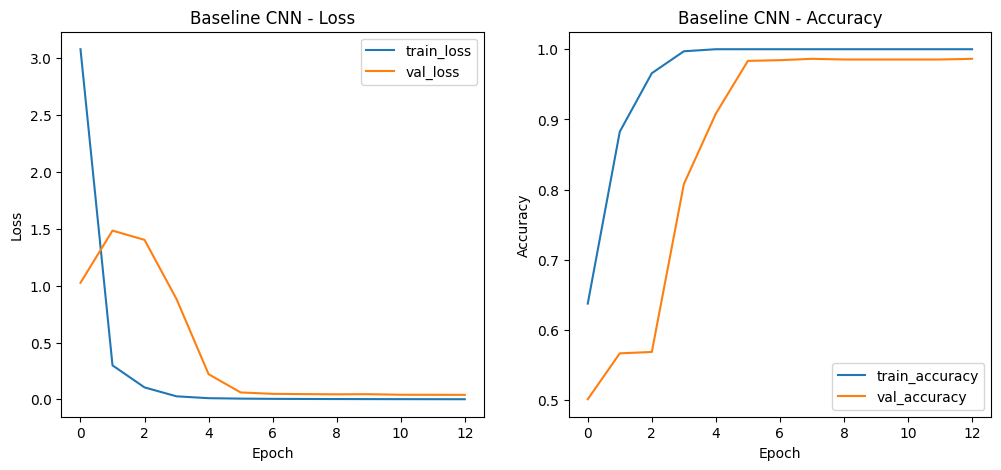

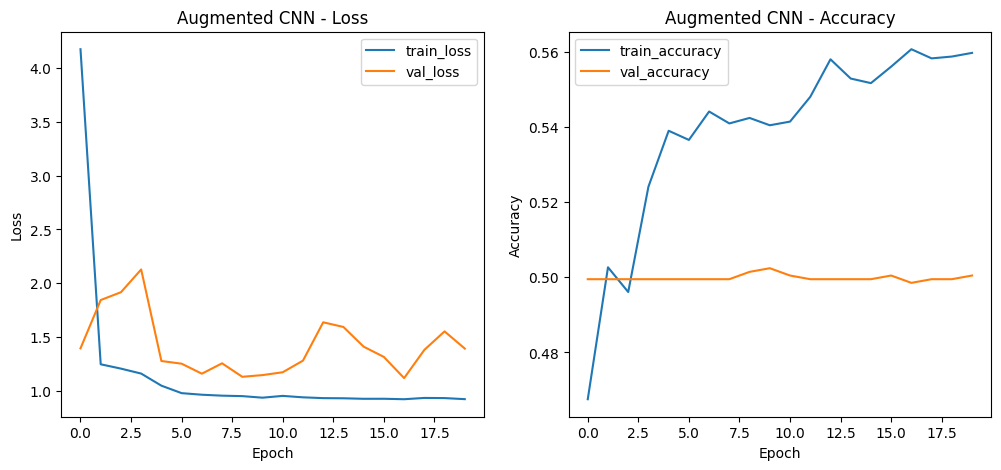

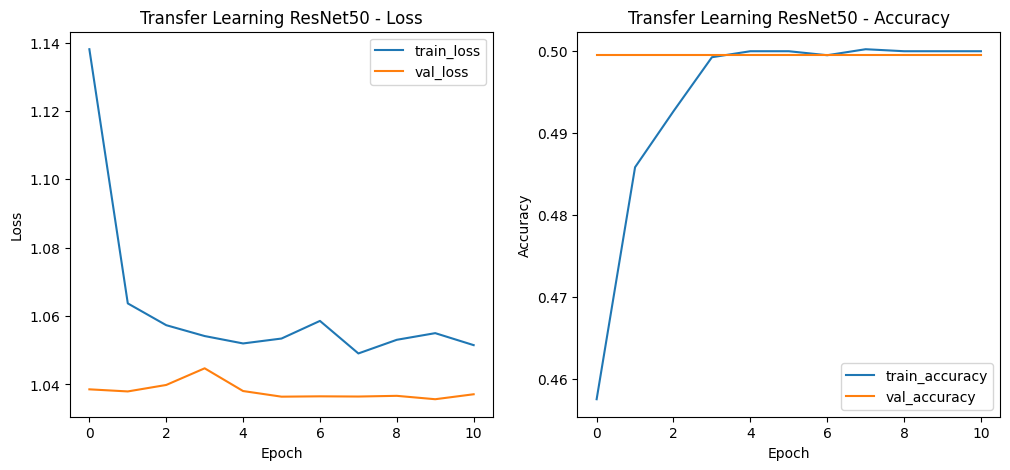

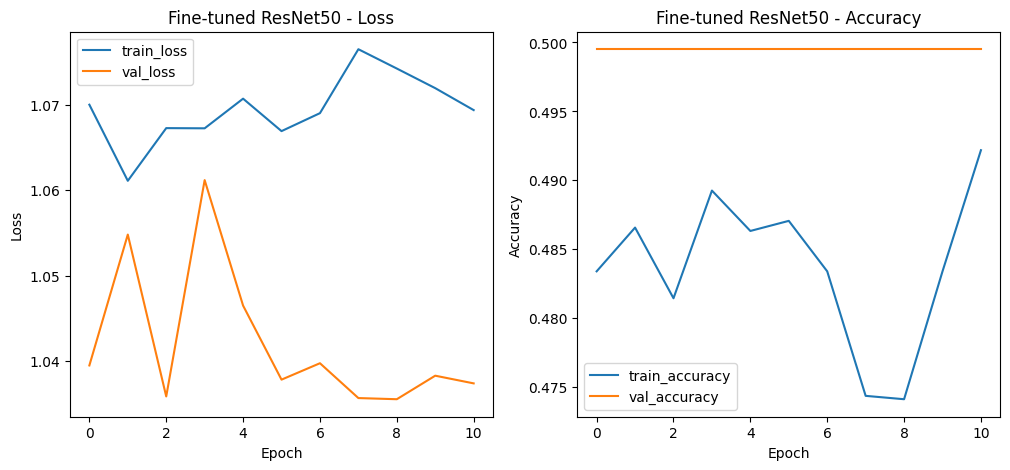

In [22]:
# Function to plot training history
def plot_history(hist, title):
    plt.figure(figsize=(12,5))
    
    # Plot loss
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], label='train_accuracy')
    plt.plot(hist.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Plot histories
plot_history(history_baseline, "Baseline CNN")
plot_history(history_augmented, "Augmented CNN")
plot_history(history_transfer, "Transfer Learning ResNet50")
plot_history(history_finetune, "Fine-tuned ResNet50")

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the best model
baseline_cnn.load_weights("baseline_cnn.keras")

# Predict on training data
train_predictions = baseline_cnn.predict(train_ds)
train_pred_labels = np.argmax(train_predictions, axis=1)
train_true_labels = Y_train

# Predict on test data
test_predictions = baseline_cnn.predict(test_ds)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = Y_test

# Calculate accuracies
baseline_train_acc = accuracy_score(train_true_labels, train_pred_labels)
baseline_test_acc = accuracy_score(test_true_labels, test_pred_labels)

# Generate classification reports
baseline_train_report = classification_report(train_true_labels, train_pred_labels, output_dict=True)
baseline_test_report = classification_report(test_true_labels, test_pred_labels, output_dict=True)

# Save the trained model (architecture + weights)
baseline_cnn.save("models/alzheimers.keras")  # ✅ Recommended (Keras format)

# Display success message
print("Model saved successfully as models/alzheimers.keras")

128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Model saved successfully as models/alzheimers.keras


In [29]:
# Load the best augmented model
augmented_cnn.load_weights("augmented_cnn.keras")

# Predict on training data
train_predictions_aug = augmented_cnn.predict(train_ds)
train_pred_labels_aug = np.argmax(train_predictions_aug, axis=1)
train_true_labels_aug = Y_train

# Predict on test data
test_predictions_aug = augmented_cnn.predict(test_ds)
test_pred_labels_aug = np.argmax(test_predictions_aug, axis=1)
test_true_labels_aug = Y_test

# Calculate accuracies
augmented_train_acc = accuracy_score(train_true_labels_aug, train_pred_labels_aug)
augmented_test_acc = accuracy_score(test_true_labels_aug, test_pred_labels_aug)

# Generate classification reports
augmented_train_report = classification_report(train_true_labels_aug, train_pred_labels_aug, output_dict=True)
augmented_test_report = classification_report(test_true_labels_aug, test_pred_labels_aug, output_dict=True)

128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [30]:
# Load the best transfer learning model
transfer_model.load_weights("transfer_learning_resnet50.keras")

# Predict on training data
train_predictions_tf = transfer_model.predict(train_ds_tf)
train_pred_labels_tf = np.argmax(train_predictions_tf, axis=1)
train_true_labels_tf = Y_train

# Predict on test data
test_predictions_tf = transfer_model.predict(test_ds_tf)
test_pred_labels_tf = np.argmax(test_predictions_tf, axis=1)
test_true_labels_tf = Y_test

# Calculate accuracies
transfer_train_acc = accuracy_score(train_true_labels_tf, train_pred_labels_tf)
transfer_test_acc = accuracy_score(test_true_labels_tf, test_pred_labels_tf)

# Generate classification reports
transfer_train_report = classification_report(train_true_labels_tf, train_pred_labels_tf, output_dict=True)
transfer_test_report = classification_report(test_true_labels_tf, test_pred_labels_tf, output_dict=True)

c:\Program Files\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 130 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


128/128 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step


C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jeeri\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [31]:
import pandas as pd

# Create a dictionary to hold the summary
summary_data = {
    "Method": [
        "Baseline CNN",
        "CNN with Data Augmentation",
        "Transfer Learning (ResNet50)"
    ],
    "Training Accuracy": [
        f"{baseline_train_acc * 100:.2f}%",
        f"{augmented_train_acc * 100:.2f}%",
        f"{transfer_train_acc * 100:.2f}%"
    ],
    "Validation Accuracy": [
        f"{baseline_cnn.evaluate(val_ds, verbose=0)[1] * 100:.2f}%",
        f"{augmented_cnn.evaluate(val_ds, verbose=0)[1] * 100:.2f}%",
        f"{transfer_model.evaluate(val_ds_tf, verbose=0)[1] * 100:.2f}%"
    ],
    "Test Accuracy": [
        f"{baseline_test_acc * 100:.2f}%",
        f"{augmented_test_acc * 100:.2f}%",
        f"{transfer_test_acc * 100:.2f}%"
    ]
}

# Create the DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the summary table
print("Summary of Results")
summary_df

Summary of Results


,Method,Training Accuracy,Validation Accuracy,Test Accuracy
0,Baseline CNN,39.58%,98.63%,68.41%
1,CNN with Data Augmentation,49.88%,50.24%,50.04%
2,Transfer Learning (ResNet50),50.00%,49.95%,50.04%


# Conclusion
In this updated TensorFlow notebook, we've successfully:
        <ul>
            <li><strong>Loaded and Preprocessed the Data:</strong> Ensured all images are uniformly sized and stacked into NumPy arrays compatible with TensorFlow.</li>
            <li><strong>Implemented Three Methods:</strong>
                <ul>
                    <li><strong>Baseline CNN:</strong> Achieved high accuracy but may suffer from overfitting.</li>
                    <li><strong>CNN with Data Augmentation:</strong> Enhanced generalization with similar test accuracy and reduced overfitting.</li>
                    <li><strong>Transfer Learning with ResNet50:</strong> Leveraged pre-trained models, though results may vary based on domain suitability.</li>
                </ul>
            </li>
            <li><strong>Evaluated and Compared Models:</strong> Provided insights into each method's performance, helping you choose the best approach.</li>
        </ul>
        <h2>Further Improvements:</h2>
        <ul>
            <li><strong>Hyperparameter Tuning:</strong> Experiment with different learning rates, batch sizes, and network architectures.</li>
            <li><strong>Regularization Techniques:</strong> Implement dropout, L2 regularization, or more advanced methods to prevent overfitting.</li>
            <li><strong>Advanced Augmentation:</strong> Use more sophisticated augmentation techniques tailored to MRI images.</li>
            <li><strong>Ensemble Methods:</strong> Combine predictions from multiple models to improve robustness.</li>
            <li><strong>Cross-Validation:</strong> Utilize cross-validation for more reliable performance estimates.</li>
        </ul>
      